In [1]:
from utils import *
from DataGenerator import *
from Models_normal import *
import torch.optim as optim
from Analysis import fixed_model_batch_analysis

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
num = 10000

# Parameters for the first Gaussian distribution (positive label)
mean1_a = [2, 2]         # Mean of the first component of class 1
variance1_a = 0.5        # Variance of the first component of class 1
data1_a = create_random_data_normal_dist(input_dimension=2, num=int(num/2), loc=mean1_a, scale=np.sqrt(variance1_a))

mean1_b = [10, -50]       # Mean of the second component of class 1
variance1_b = 0.5        # Variance of the second component of class 1
data1_b = create_random_data_normal_dist(input_dimension=2, num=int(num/2), loc=mean1_b, scale=np.sqrt(variance1_b))

# Combine both components of class 1
data1 = np.vstack((data1_a, data1_b))

# Parameters for the second Gaussian distribution (negative label)
mean2 = [-25, -25]     # Mean of the second class (negative label)
variance2 = 100        # Variance of the second class (much larger)
data2 = create_random_data_normal_dist(input_dimension=2, num=num, loc=mean2, scale=np.sqrt(variance2))

# Combine the datasets and create labels
X = np.vstack((data1, data2))
y = np.array([1] * num + [0] * num)  # Positive labels for the first class and negative for the second


In [16]:
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

In [17]:
# Fit Gaussian Mixture Models for both classes
gmm1 = GaussianMixture(n_components=1).fit(X[y == 1])
gmm2 = GaussianMixture(n_components=1).fit(X[y == 0])


In [18]:
def estimate_decision_boundary(X, gmm1, gmm2):
    # Generate a grid to evaluate the density
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.column_stack([xx.ravel(), yy.ravel()])

    # Compute the density for both classes
    log_density1 = gmm1.score_samples(grid)
    log_density2 = gmm2.score_samples(grid)

    # Calculate the decision boundary
    decision_boundary = np.exp(log_density1) - np.exp(log_density2)
    
    return xx, yy, decision_boundary.reshape(xx.shape)


In [19]:
def plot_decision_boundary(X, y, xx, yy, decision_boundary):
    plt.figure(figsize=(10, 8))
    
    # Plot the decision boundary
    plt.contourf(xx, yy, decision_boundary, levels=50, cmap='coolwarm', alpha=0.5)
    
    # Plot data points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='bwr', alpha=0.6)
    
    # Add a legend
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title("Decision Boundary with Gaussian Mixture Models")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

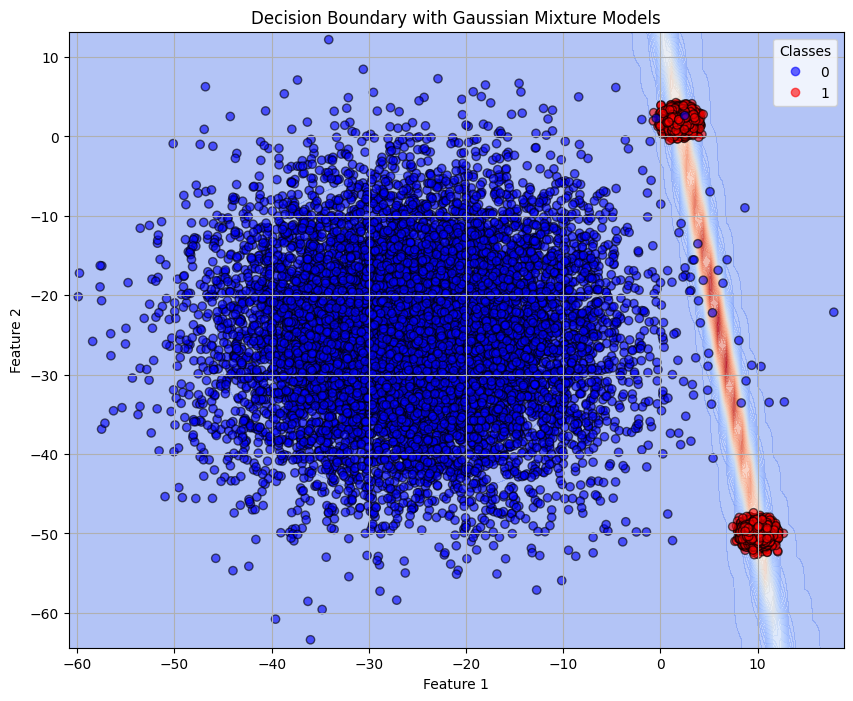

In [20]:
xx, yy, decision_boundary = estimate_decision_boundary(X, gmm1, gmm2)
plot_decision_boundary(X, y, xx, yy, decision_boundary)

Epoch [10/200], Loss: 5.2537, Train Accuracy: 50.00%
Epoch [20/200], Loss: 2.8802, Train Accuracy: 50.00%
Epoch [30/200], Loss: 1.5817, Train Accuracy: 79.70%
Epoch [40/200], Loss: 1.1216, Train Accuracy: 85.55%
Epoch [50/200], Loss: 0.8565, Train Accuracy: 88.20%
Epoch [60/200], Loss: 0.6790, Train Accuracy: 90.35%
Epoch [70/200], Loss: 0.5601, Train Accuracy: 92.85%
Epoch [80/200], Loss: 0.4843, Train Accuracy: 94.05%
Epoch [90/200], Loss: 0.4344, Train Accuracy: 95.30%
Epoch [100/200], Loss: 0.4013, Train Accuracy: 96.15%
Epoch [110/200], Loss: 0.3800, Train Accuracy: 97.15%
Epoch [120/200], Loss: 0.3677, Train Accuracy: 97.90%
Epoch [130/200], Loss: 0.3597, Train Accuracy: 98.35%
Epoch [140/200], Loss: 0.3547, Train Accuracy: 99.10%
Epoch [150/200], Loss: 0.3526, Train Accuracy: 99.60%
Epoch [160/200], Loss: 0.3516, Train Accuracy: 99.90%
Epoch [170/200], Loss: 0.3511, Train Accuracy: 100.00%
Epoch [180/200], Loss: 0.3506, Train Accuracy: 100.00%
Epoch [190/200], Loss: 0.3502, Trai

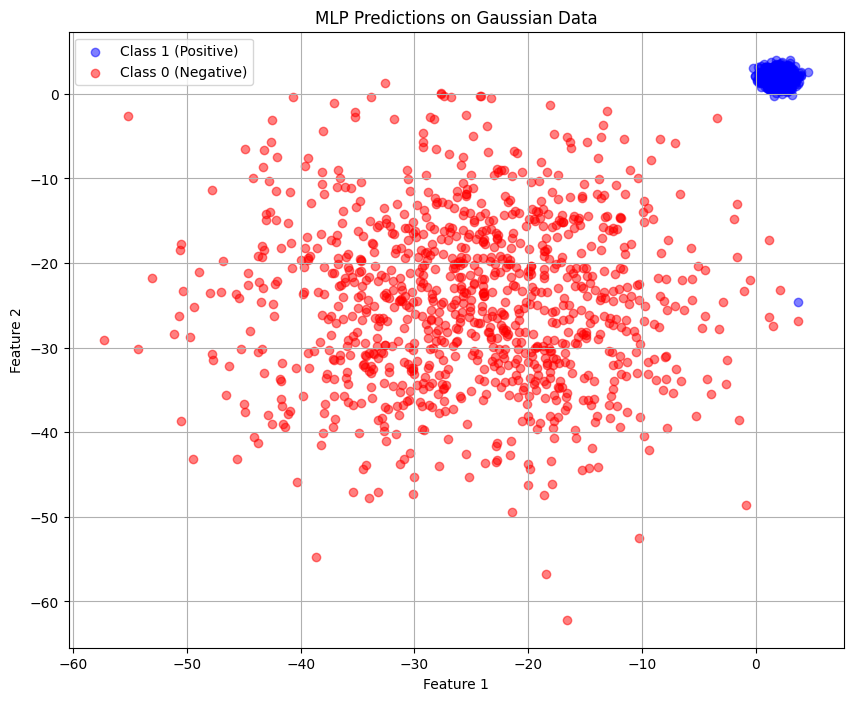

In [9]:
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32)
X = X.to(device)
y = y.to(device)

# 2. Initialize the MLP
input_dimension = X.shape[1]  # Should be 2
layer_list = [16, 8, 1]        # Hidden layers configuration
model = MLP_simple(input_dimension, layer_list).to(device)

# 3. Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.001) # type: ignore

# 4. Training loop
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear gradients
    outputs = model(X).squeeze()  # Forward pass
    loss = criterion(outputs, y)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights


    if (epoch + 1) % 10 == 0:
        # Calculate training accuracy
        with torch.no_grad():
            predictions = torch.sigmoid(outputs).squeeze()  # Apply sigmoid to get probabilities
            predicted_labels = (predictions > 0.5).float()  # Convert probabilities to binary labels
            
            train_accuracy = (predicted_labels == y).float().mean()  # Calculate accuracy

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy.item() * 100:.2f}%')

# 5. Evaluate the model
model.eval()
with torch.no_grad():
    predictions = torch.sigmoid(model(X)).squeeze()  # Apply sigmoid to get probabilities
    predicted_labels = (predictions > 0.5).float()    # Convert probabilities to binary labels

X = X.detach().cpu()
predicted_labels = predicted_labels.detach().cpu()

# Visualization of the results
plt.figure(figsize=(10, 8))
plt.scatter(X[predicted_labels == 1][:, 0], X[predicted_labels == 1][:, 1], color='blue', label='Class 1 (Positive)', alpha=0.5)
plt.scatter(X[predicted_labels == 0][:, 0], X[predicted_labels == 0][:, 1], color='red', label='Class 0 (Negative)', alpha=0.5)
plt.title("MLP Predictions on Gaussian Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid()
plt.show()

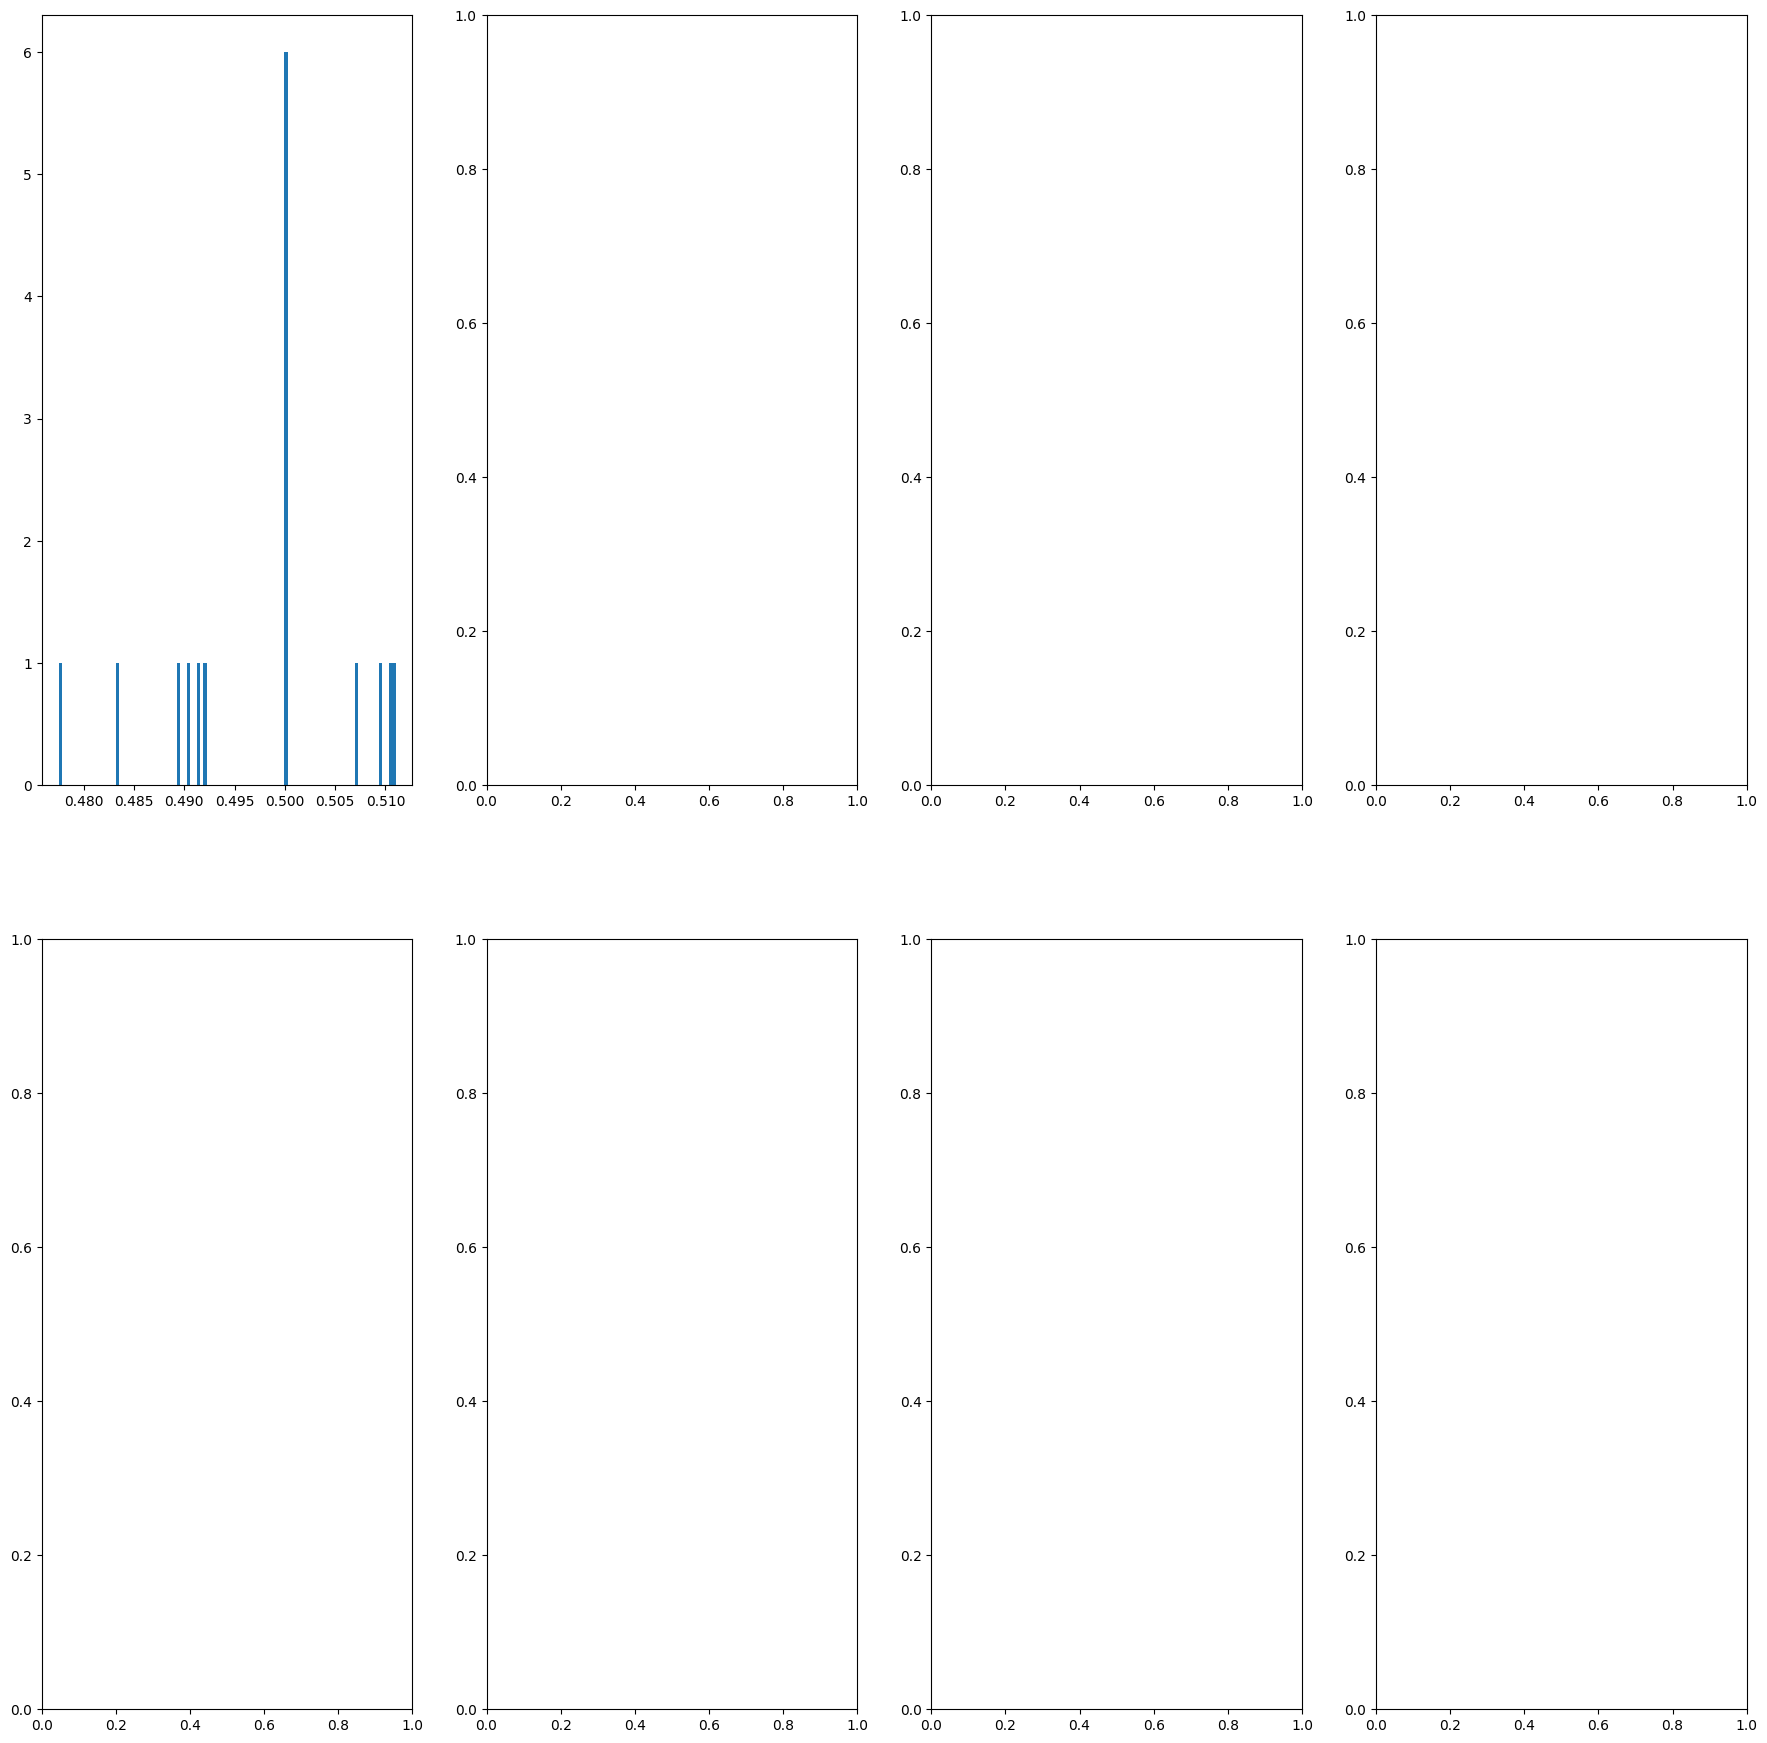

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
this_path = 'bayesian_est/'
if not os.path.isdir(this_path):
    os.makedirs(this_path)

fixed_model_batch_analysis(model=model , samples=X, labels=y, device=device, save_path=this_path, model_status='2, 16, 8, 1')